In [121]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # for heatmap
import matplotlib.pyplot as plt # for common plotting
import graphviz as gv # for decision tree plotting
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
# GaussianNB, BernoulliNB, MultinomialNB
from sklearn.naive_bayes import GaussianNB as bayes_model
from sklearn.metrics import r2_score as model_score, classification_report, confusion_matrix, accuracy_score
from sklearn import tree

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
animals = pd.read_csv("../input/train/train.csv")
test = pd.read_csv("../input/test/test.csv")
# Any results you write to the current directory are saved as output.
animals.head(3)

['train_sentiment', 'test', 'breed_labels.csv', 'train', 'test_images', 'test_sentiment', 'test_metadata', 'color_labels.csv', 'train_metadata', 'train_images', 'state_labels.csv']


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3


* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to StateLabels dictionary)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.
* PetID - Unique hash ID of pet profile
* PhotoAmt - Total uploaded photos for this pet
* AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.

In [ ]:
animals.describe()

Tipos de Variables
Cualitativas:
* Type
* Name
* Breed1
* Breed2
* Gender
* Color1
* Color2
* Color3
* Vaccinated
* Dewormed
* Sterilized
* State
* RescuerID
* Description
* PetID

Cuantitativas
* MaturitySize
* FurLength
* Helmuth
* Quantity
* Fee
* VideoAmt
* PhotoAmt
* AdoptionSpeed

In [ ]:
animalsBySpeed = animals.groupby(['AdoptionSpeed']).size().reset_index(name='Count')
dataToPlot = pd.DataFrame({'Percentage': pd.Series(animalsBySpeed.apply(lambda row: row['Count']/len(animals),axis=1), index=animalsBySpeed.index)})
dataToPlot.set_index([['Same Day','1st week','1st Month','2nd & 3rd Month','Other']], inplace=True)
dataToPlot

In [ ]:
dataToPlot.plot.pie(y='Percentage', figsize=(10,10))

Se consideró si difería la cantidad de adopciones según el tiempo que la mascota teniene sin ser adoptada. Con los datos anteriores solo se puede afirmar que las mascotas con más de 3 meses poseen menos probabilidad de ser adoptadas.

In [ ]:
animalsByType = animals.groupby(['Type']).size().reset_index(name='Count')
animalsByType.plot.barh(y='Count',x='Type')

En la base de datos que posee PetFinder hay más caninos que feninos

In [ ]:
animals['Age'].corr(animals['AdoptionSpeed'])

Suponiendo que las personas prefieren animales más jovenes para adoptar, esto parece que no sucede en PetFinder donde existen mascotas con menos de un mes hasta mascotas con más 20 años.

In [ ]:
corr = animals.corr()
# plot the heatmap
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.5, square=True)

Luego de obtener el resultado se buscó correlación significativa para las demás variables pero unicamente existe esta para las variables Vaccinated, Dewormed, Sterilzed.

**Grafica de Codo:**

In [ ]:
animalsBow = animals._get_numeric_data()
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(animalsBow)
    kmeanModel.fit(animalsBow)
    distortions.append(sum(np.min(cdist(animalsBow, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / animalsBow.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Al realizar la grafica codo se considera utilizar 6 para cantidad de grupos del cluster

**Agrupación con K-Medias:**

In [ ]:
features = animals[['Age', 'MaturitySize', 'FurLength', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'AdoptionSpeed']]
kmeans = KMeans(n_clusters = 6).fit_predict(features)
rows, cols = features.shape
fig, axs = plt.subplots(cols, cols,figsize=(50, 50))
for i in range(0, cols):
    for j in range(0, cols):
        if j != i:
            axs[i, j].scatter(features.iloc[:,i], features.iloc[:,j], c=kmeans)
            axs[i,j].set(xlabel=features.columns[i],ylabel=features.columns[j])
plt.show()

 **Predicción usando un árbol de decisiones:**

In [ ]:
#features = animals.drop(['Name', 'RescuerID', 'PetID', 'Description', 'Quantity', 'Vaccinated', 'AdoptionSpeed'], axis=1)
features = animals[['Age', 'MaturitySize', 'FurLength', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']]
speed = animals[['AdoptionSpeed']]
classifier = tree.DecisionTreeClassifier().fit(features, speed)
cleaned_test = test[['Age', 'MaturitySize', 'FurLength', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']]
#cleaned_test = test.drop(['Name', 'RescuerID', 'PetID', 'Description', 'Quantity', 'Vaccinated'], axis=1)
prediction = classifier.predict(cleaned_test)
prediction

In [ ]:
graph_data = tree.export_graphviz(classifier, out_file=None, max_depth=5)
graph = gv.Source(graph_data)
graph

In [ ]:
result = test[['PetID']].assign(AdoptionSpeed=pd.Series(prediction))
result.to_csv('submission.csv', index=False)

La precisión del modelo fue de 0.169, por lo que se concluye que el modelo basado en un árbol de decisiones con las variables utilizadas no es nada eficaz.

**Predicción de la variable *Fee* utilizando un modelo de Regresión Lineal:**

In [ ]:
myvar = animals[['Dewormed','Vaccinated','Sterilized','Fee']].copy()
myvar['Total'] = myvar.sum(axis=1)
corr = myvar.corr()
# plot the heatmap
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.5, square=True)

In [ ]:
myvar['Total'].corr(myvar['Fee'])

In [ ]:
fig, axs = plt.subplots(2, 1)

#Con datos del dataset train
#data_x = myvar.drop('Fee', axis=1)
data_x = myvar[['Total']].copy()
data_y = myvar[['Fee']].copy()
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.3, random_state=42)
lm = LinearRegression()
lm.fit(train_x, train_y)
pred = lm.predict(test_x)
axs[0].scatter(test_y, pred)
print('Puntuación usando train:', model_score(test_y, pred))
#Con datos del dataset test
lm2 = LinearRegression()
lm2.fit(data_x, data_y)
real_test = test[['Dewormed','Vaccinated','Sterilized']].copy()
real_test['Total'] = real_test.sum(axis=1)
pred2 = lm2.predict(real_test[['Total']].copy())
axs[1].scatter(test[['Fee']], pred2, color='red')
print('Puntuación usando test:', model_score(test[['Fee']], pred2))


Utilizando la suma de las variables **Dewormed**, **Vaccinated** y **Sterilized** para predecir los valores de la variable **Fee** en un modelo de regresión lineal, se observó un caso de *Overfitting*. Como se puede observar en la sección anterior, entrenando el modelo con una porción del dataset "train" y utilizando el resto para realizar la predicción se obtuvo un puntaje de 0.99 (valor obtenido al utilizar la función R^2 sobre la predicción y los valores reales). En contraste, al usar todo el dataset "train" para entrenar el modelo y el dataset "test" para realizar las predicciones, se obtuvo un puntaje de -0.103, lo cual muestra que el modelo no funciona al utilizar datos totalmente ajenos a los datos de entrenamiento.

**Naive Bayes:**

In [ ]:
animals2 = animals._get_numeric_data()
x_train, x_test = train_test_split(animals2, test_size=0.3, random_state=1)
gnb = bayes_model()
used_features = list(animals2)[:len(list(animals2))-2]
print(used_features)
# Train classifier
gnb.fit(
    x_train[used_features].values,
    x_train["AdoptionSpeed"]
)
pred = gnb.predict(x_test[used_features])
print('Puntuación usando test:', model_score(x_test['AdoptionSpeed'], pred))
print(classification_report(x_test['AdoptionSpeed'], pred))
print(confusion_matrix(x_test['AdoptionSpeed'], pred))

Como se puede ver en la puntuación del modelo usando el test de R^2 y en el reporte de clasificación, el modelo de bayes tampoco fue eficaz para la predicción de la velocidad de adopción.

**Regresión logística**

Se crean variables "dummy" para cada valor del AdoptionSpeed y se eliminan las columnas innecesarias (encontradas en análisis anteriores).

In [132]:
lambdafunc = lambda x: pd.Series([1 if x['AdoptionSpeed']==0 else 0,1 if x['AdoptionSpeed']==1 else 0, 1 if x['AdoptionSpeed']==2 else 0, 1 if x['AdoptionSpeed']==3 else 0, 1 if x['AdoptionSpeed']==4 else 0])
animals[['var0','var1', 'var2', 'var3','var4']] = animals.apply(lambdafunc, axis=1)
categoric_animals = animals.drop(['Name', 'Description', 'PetID', 'RescuerID', 'VideoAmt', 'State', 'Vaccinated', 'Quantity'], axis=1)
categoric_animals.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Dewormed,Sterilized,Health,Fee,PhotoAmt,AdoptionSpeed,var0,var1,var2,var3,var4
0,2,3,299,0,1,1,7,0,1,1,2,2,1,100,1.0,2,0,0,1,0,0
1,2,1,265,0,1,1,2,0,2,2,3,3,1,0,2.0,0,1,0,0,0,0
2,1,1,307,0,1,2,7,0,2,2,1,2,1,0,7.0,3,0,0,0,1,0
3,1,4,307,0,2,1,2,0,2,1,1,2,1,150,8.0,2,0,0,1,0,0
4,1,1,307,0,1,1,0,0,2,1,2,2,1,0,3.0,2,0,0,1,0,0


Para cada columna de las variables "dummy" se correrá el algoritmo de regresión logística para encontrar la probabilidad de que una fila pertenezca a una categoría de AdoptionSpeed. Luego se procederá a asignarle a cada fila del set de pruebas, el valor que representa a la categoría con mayor probabilidad para dicha fila.

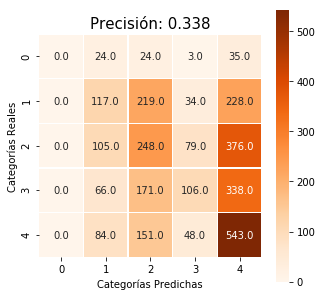

In [146]:
no_var_animals = categoric_animals.drop(['var0', 'var1', 'var2', 'var3', 'var4', 'AdoptionSpeed'], axis=1)
var_animals = categoric_animals[['var0', 'var1', 'var2', 'var3', 'var4', 'AdoptionSpeed']].copy() #AdoptionSpeed se omitirá más adelante

x_train, x_test, y_train, y_test = train_test_split(no_var_animals, var_animals, test_size=0.20, random_state=114)

var_col_names = var_animals.columns.values
var_col_names = var_col_names[0: len(var_col_names)-1] #Se borra AdoptionSpeed de los nombres de las columnas sobre las que se correra el algoritmo

all_predictions = pd.DataFrame()
for col in var_col_names:  
    lg = LogisticRegression(solver='liblinear')
    lg.fit(x_train, y_train[[col]].values.ravel())
    prediction = lg.predict_proba(x_test)
    all_predictions[col] = pd.Series(np.array(prediction)[:, 1])
    
def bigger_probability(row):
    selected = 0
    for i in range(1, len(row)):
        if row[i] > row[selected]:
            selected = i
    return selected

result = all_predictions.apply(lambda x: bigger_probability(x), axis=1).values

score = accuracy_score(y_test['AdoptionSpeed'], result)
cm = confusion_matrix(y_test['AdoptionSpeed'], result)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Oranges');
plt.ylabel('Categorías Reales');
plt.xlabel('Categorías Predichas');
title = 'Precisión: {}'.format(round(score, 3))
plt.title(title, size = 15);

Como se observa en la precisión final, el algoritmo de regresión logística resultó ser mucho más efectivo para este set de datos, siendo esta de un 33.8%. Esto se debe principalmente a la naturaleza de la mayoría de las columnas del dataset, las cuales son categóricas. Sin embargo, se debe mencionar que por la misma razón, las métricas utilizadas para medir el desempeño de este algoritmo fueron distintas a las del resto. Por lo que para poder comparar este algoritmo con el resto, es necesario cambiar los procedimientos utilizados en los anteriores.